In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
def compute_accuracy_metric(predict_hr_fft_all,gt_hr_fft_all):

    # calculate absolute difference between the arrays
    abs_diff = np.abs(predict_hr_fft_all - gt_hr_fft_all)

    # calculate the maximum allowed difference (currently: 2 bpm like the accuracy of a fingerclip PPG)
    max_allowed_diff = 2

    # Check how much elements have an absolute difference less than the maximum allowed difference
    correct_predictions = abs_diff <= max_allowed_diff
    Accuracy = 100 * np.sum(correct_predictions) / predict_hr_fft_all.shape[0]
    return Accuracy

In [9]:
angle = 30
results=dict()
dataset="UBFC-rPPG"
#TODO make sure all Interpolated an same segmentation
all_datasets = ["KISMED","UBFC-rPPG","PURE","RLAP","VIPL-HR-V1","MMPD","COHFACE"] 
super_super_summary = list()
for dataset in all_datasets:
    for angle in [15,20,25,30,35,40,45,50,60,70,90]:
        if dataset=="UBFC-rPPG":
            path_estim_HR = f"../data/HR_log_angle_eval/UBFC-rPPG_SzW72_SzH72_ClipLen180_DataTypeRaw_DataAugNone_LabelTypeRaw_ROI_segmeTrue_Angle_thres{angle}_Interp_AngleTrue_ROI_mode-optimal_roi_Use_convex_hullTrue_Constr_roiFalse_Outs_roiTrue_unsupervised"
        elif dataset=="KISMED":
            path_estim_HR = f"../data/HR_log_angle_eval/KISMED_SzW72_SzH72_ClipLen180_DataTypeRaw_DataAugNone_LabelTypeRaw_ROI_segmeTrue_Angle_thres{angle}_Interp_AngleTrue_ROI_mode-optimal_roi_Use_convex_hullTrue_Constr_roiFalse_Outs_roiTrue_unsupervised"
        elif dataset=="PURE":
            path_estim_HR = f"../data/HR_log_angle_eval/PURE_SzW72_SzH72_ClipLen180_DataTypeRaw_DataAugNone_LabelTypeRaw_ROI_segmeTrue_Angle_thres{angle}_Interp_AngleTrue_ROI_mode-optimal_roi_Use_convex_hullTrue_Constr_roiFalse_Outs_roiTrue_unsupervised"
        elif dataset=="RLAP":
            path_estim_HR = f"../data/HR_log_angle_eval/RLAP_SzW72_SzH72_ClipLen180_DataTypeRaw_DataAugNone_LabelTypeRaw_ROI_segmeTrue_Angle_thres{angle}_Interp_AngleTrue_ROI_mode-optimal_roi_Use_convex_hullTrue_Constr_roiFalse_Outs_roiTrue_unsupervised"
        elif dataset=="RLAP-NoIP":
            path_estim_HR = f"../data/HR_log_angle_eval/RLAP_SzW72_SzH72_ClipLen180_DataTypeRaw_DataAugNone_LabelTypeRaw_ROI_segmeTrue_Angle_thres{angle}_Interp_AngleFalse_ROI_mode-optimal_roi_Use_convex_hullTrue_Constr_roiFalse_Outs_roiTrue_unsupervised"
        elif dataset=="VIPL-HR-V1":
            path_estim_HR = f"../data/HR_log_angle_eval/VIPL-HR-V1_SzW72_SzH72_ClipLen180_DataTypeRaw_DataAugNone_LabelTypeRaw_ROI_segmeTrue_Angle_thres{angle}_Interp_AngleTrue_ROI_mode-optimal_roi_Use_convex_hullTrue_Constr_roiFalse_Outs_roiTrue_unsupervised"
        elif dataset=="MMPD":
            path_estim_HR = f"../data/HR_log_angle_eval/MMPD_SzW72_SzH72_ClipLen180_DataTypeRaw_DataAugNone_LabelTypeRaw_ROI_segmeTrue_Angle_thres{angle}_Interp_AngleTrue_ROI_mode-optimal_roi_Use_convex_hullTrue_Constr_roiFalse_Outs_roiTrue_unsupervised"
        elif dataset=="COHFACE":
            path_estim_HR = f"../data/HR_log_angle_eval/COHFACE_SzW72_SzH72_ClipLen180_DataTypeRaw_DataAugNone_LabelTypeRaw_ROI_segmeTrue_Angle_thres{angle}_Interp_AngleTrue_ROI_mode-optimal_roi_Use_convex_hullTrue_Constr_roiFalse_Outs_roiTrue_unsupervised"
        
        methods=list()
        method_names=list()
        MAEs=list()
        RMSEs = list()
        SNR_m = list()
        PEARSONS = list()
        ACCURACIES = list()
        for file in sorted(os.listdir(path_estim_HR)):
            m_name = file.split('_')[-1].split('.')[0]
            method_names.append(m_name)
            _df = pd.read_csv(os.path.join(path_estim_HR,file))
            _df['angle']=np.ones(len(_df))*angle
            preds = _df['predict_hr_fft_all']
            gt = _df['gt_hr_fft_all']
            snrs = _df['SNR_all']
            errors=preds-gt
            MAEs.append(np.mean(np.abs(preds-gt)))
            RMSEs.append(np.sqrt(np.mean((preds-gt)**2)))
            Pearson_FFT = np.corrcoef(preds, gt)
            PEARSONS.append(Pearson_FFT[0][1])
            SNR_m.append(snrs.mean())
            ACCURACIES.append(compute_accuracy_metric(preds,gt))
            _df['errors']=errors
            methods.append(_df)
        summary = pd.DataFrame({'angle':np.ones(len(method_names))*angle,'method_name':method_names,'MAE':MAEs,'RMSE':RMSEs,'SNR':SNR_m,'PEARSON':PEARSONS,'Accuracy':ACCURACIES})
        results[angle]={'fine':methods,'summary':summary}
    super_summary = [results[_a]['summary'] for _a in results.keys() ]
    super_summary = pd.concat(super_summary,ignore_index=True)
    super_summary = super_summary.sort_values(by=['method_name','angle'], ascending=[True,True]).reset_index(drop=True)
    super_summary["dataset_name"]=dataset
    super_super_summary.append(super_summary)
super_super_summary =  pd.concat(super_super_summary,ignore_index=True)

In [14]:
# compute the averages over all datasets for each method and add it to the dataframe

df = super_super_summary.copy()

unique_combinations = df[['angle', 'method_name']].drop_duplicates()

# Create a list to store new rows
new_rows = []

# Iterate over each unique combination of angle and method_name
for _, row in unique_combinations.iterrows():
    angle_value = row['angle']
    method_value = row['method_name']
    
    # Step 1: Filter the DataFrame by the specific angle and method_name
    filtered_df = df[(df['angle'] == angle_value) & (df['method_name'] == method_value)]

    # Step 2: Calculate the averages of the selected columns
    avg_mae = filtered_df['MAE'].mean()
    avg_rmse = filtered_df['RMSE'].mean()
    avg_snr = filtered_df['SNR'].mean()
    avg_pearson = filtered_df['PEARSON'].mean()
    avg_accuracy = filtered_df['Accuracy'].mean()

    # Step 3: Create a new row with the computed averages and set dataset_name as 'average'
    avg_row = {
        'angle': angle_value,
        'method_name': method_value,
        'MAE': avg_mae,
        'RMSE': avg_rmse,
        'SNR': avg_snr,
        'PEARSON': avg_pearson,
        'Accuracy': avg_accuracy,
        'dataset_name': 'average'
    }

    # Step 4: Add the new row to the list of new rows
    new_rows.append(avg_row)

# Step 5: Append all new rows to the DataFrame at once
avg_df = pd.DataFrame(new_rows)
df = pd.concat([df, avg_df], ignore_index=True)

super_super_summary = df


/tmp/ipykernel_868224/2398212312.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(2,2,p_idx+1)


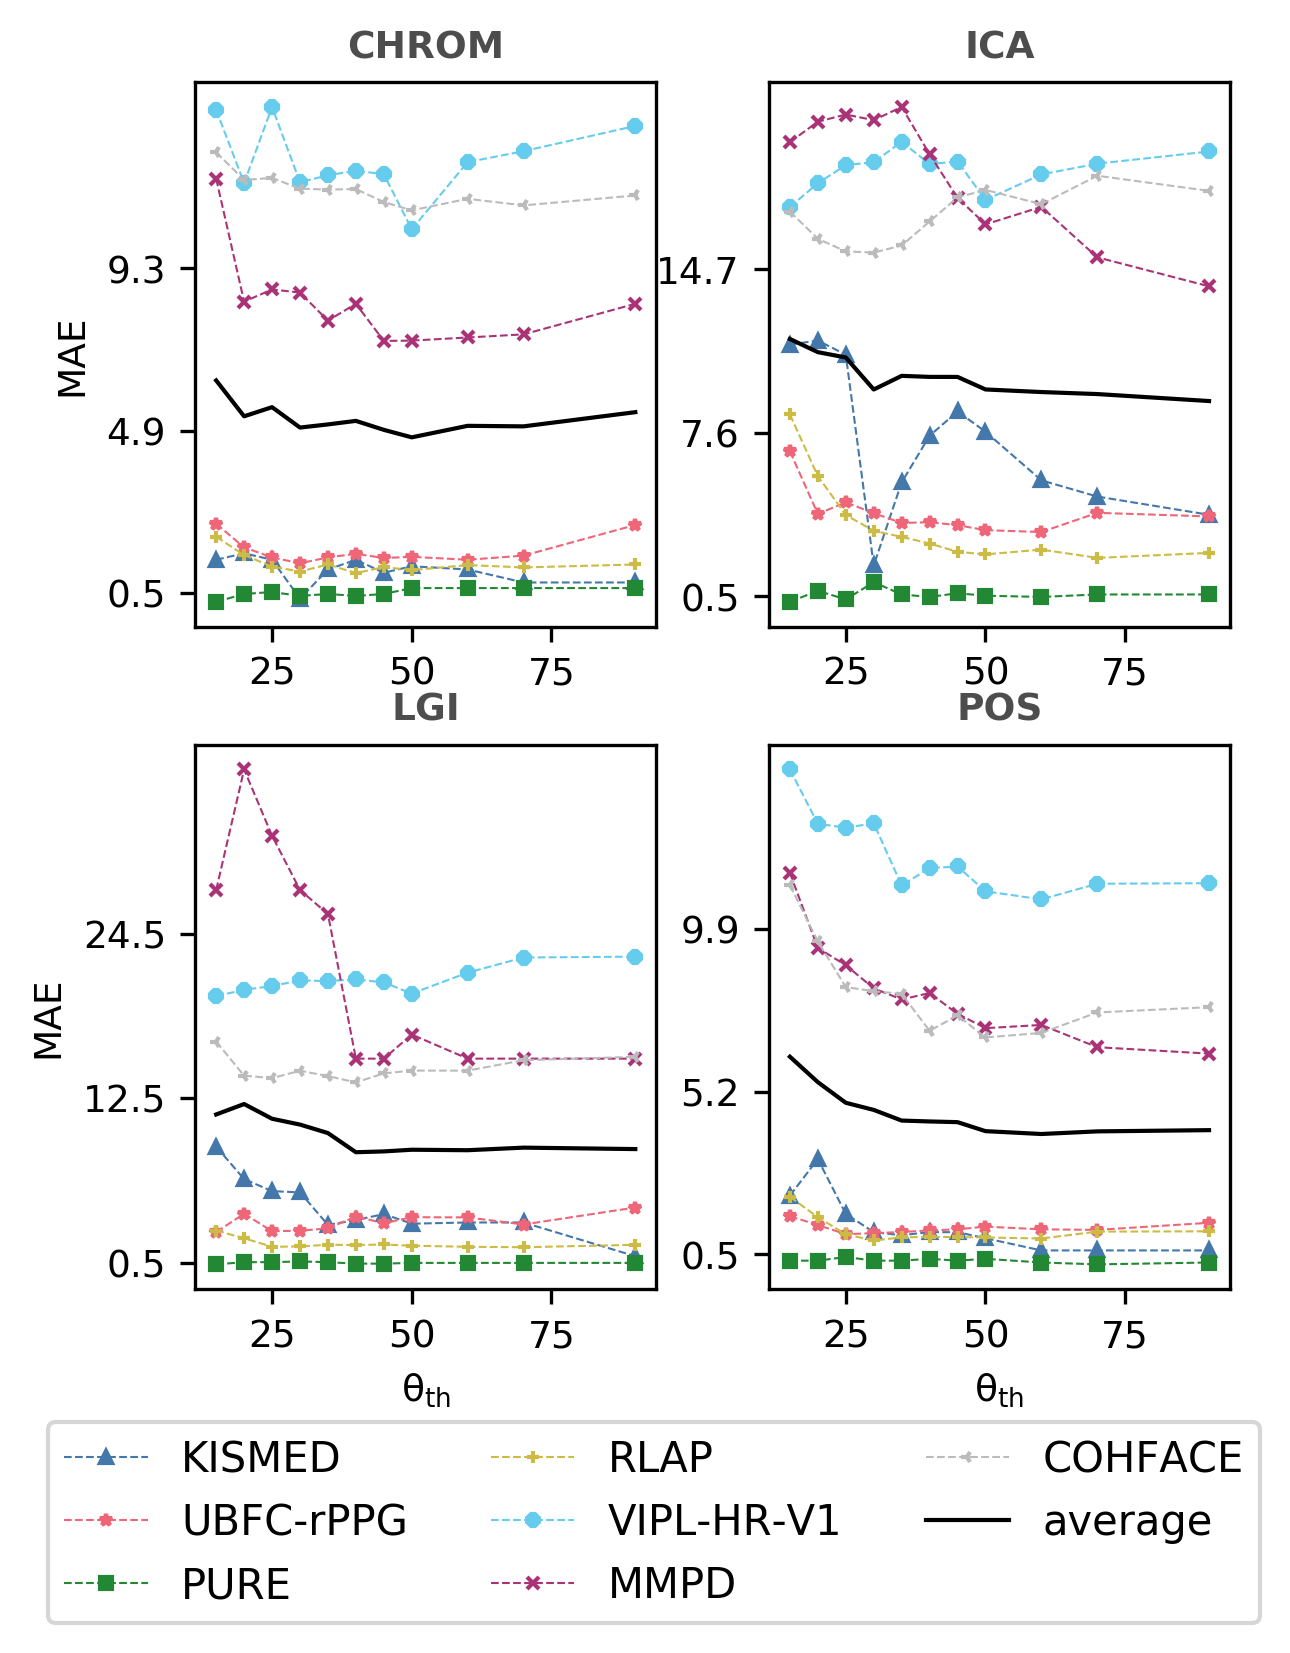

In [21]:
# Create a plot
from tol_colors import tol_cset
plt.rc('axes', prop_cycle=plt.cycler('color', list(tol_cset('bright'))))
#fig,axs = plt.subplots(2,2,figsize=(10, 6))      
plt.rcParams['mathtext.default']='regular' 
plt.rcParams['text.usetex'] = False
plt.rcParams['figure.dpi'] = 300
plt.rcParams['xtick.labelsize']=9 
plt.rcParams['ytick.labelsize']=9 
#plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(4.0, 4.6))
plt.subplots_adjust(hspace=0.5)

use_metric='MAE'
plot_sets = all_datasets.copy()
plot_sets.append("average")



# Plot MAE over angle for each method
use_markers= ["^","*","s","+","8","x","3"," "]
linestyles = ["--"]*7+["-"]
linewidth = [0.5]*7+[1]
for p_idx,method in enumerate([m for m in method_names if m not in ["PBV","GREEN"]]):
    for d_idx,d_name in enumerate(plot_sets):
        # Filter dataframe for the current method
        method_df = super_super_summary[(super_super_summary['method_name'] ==method) & (super_super_summary['dataset_name'] ==d_name)]
        
        # Plot MAE vs. angle
        ax = plt.subplot(2,2,p_idx+1)
        ax.plot(method_df['angle'].to_numpy(), method_df[use_metric].to_numpy(), label=d_name,marker=use_markers[d_idx],linestyle=linestyles[d_idx],linewidth=linewidth[d_idx],markersize=3)
    ax.set_title(method,fontsize=9,color=[0.3,0.3,0.3],weight='bold')
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    #ax.legend(loc='upper right')
    if p_idx==0 or p_idx==2:
        ax.set_ylabel(use_metric,fontsize=9)
    if p_idx==2 or p_idx==3:
        ax.set_xlabel('$θ_{th}$',fontsize=9)
    _max_value = super_super_summary[(super_super_summary['method_name'] ==method)][use_metric].max()
    if use_metric=="MAE":
        ax.set_yticks(np.arange(0.5,_max_value,np.round((_max_value-0.5)/3,1)))
    
#plt.legend(bbox_to_anchor=(0,1.02, 0.2,0.2), loc="upper left")
#plt.legend(loc='lower center', bbox_to_anchor=(-0.15,-0.6),ncol=2)
#ax.get_legend().set_title('Dataset')
fig = plt.gcf()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,loc='lower center',ncol=3,bbox_to_anchor = (0.02, -0.17, 1, 1),
           bbox_transform = plt.gcf().transFigure)

# Add labels and title
# axs.xlabel('Angle')
# plt.ylabel('MAE')
# plt.title('MAE over Angle for each Method')
# plt.legend(title='Method')
plt.tight_layout(pad=0,rect=[0, 0, 1, 1])
plt.savefig(f"figs/angle_evaluation_{use_metric}.svg",bbox_inches = 'tight')
plt.savefig(f"figs/angle_evaluation_{use_metric}.png",bbox_inches = 'tight')
plt.savefig(f"figs/angle_evaluation_{use_metric}.pdf",bbox_inches = 'tight')
#plt.savefig("figs/angle_evaluation.pgf",bbox_inches = 'tight') #requires latex installation
plt.show()


In [8]:
super_super_summary.to_csv("summary_statistics_angle_evaluation.csv")

/tmp/ipykernel_4136782/1199412826.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(2,2,p_idx+1)


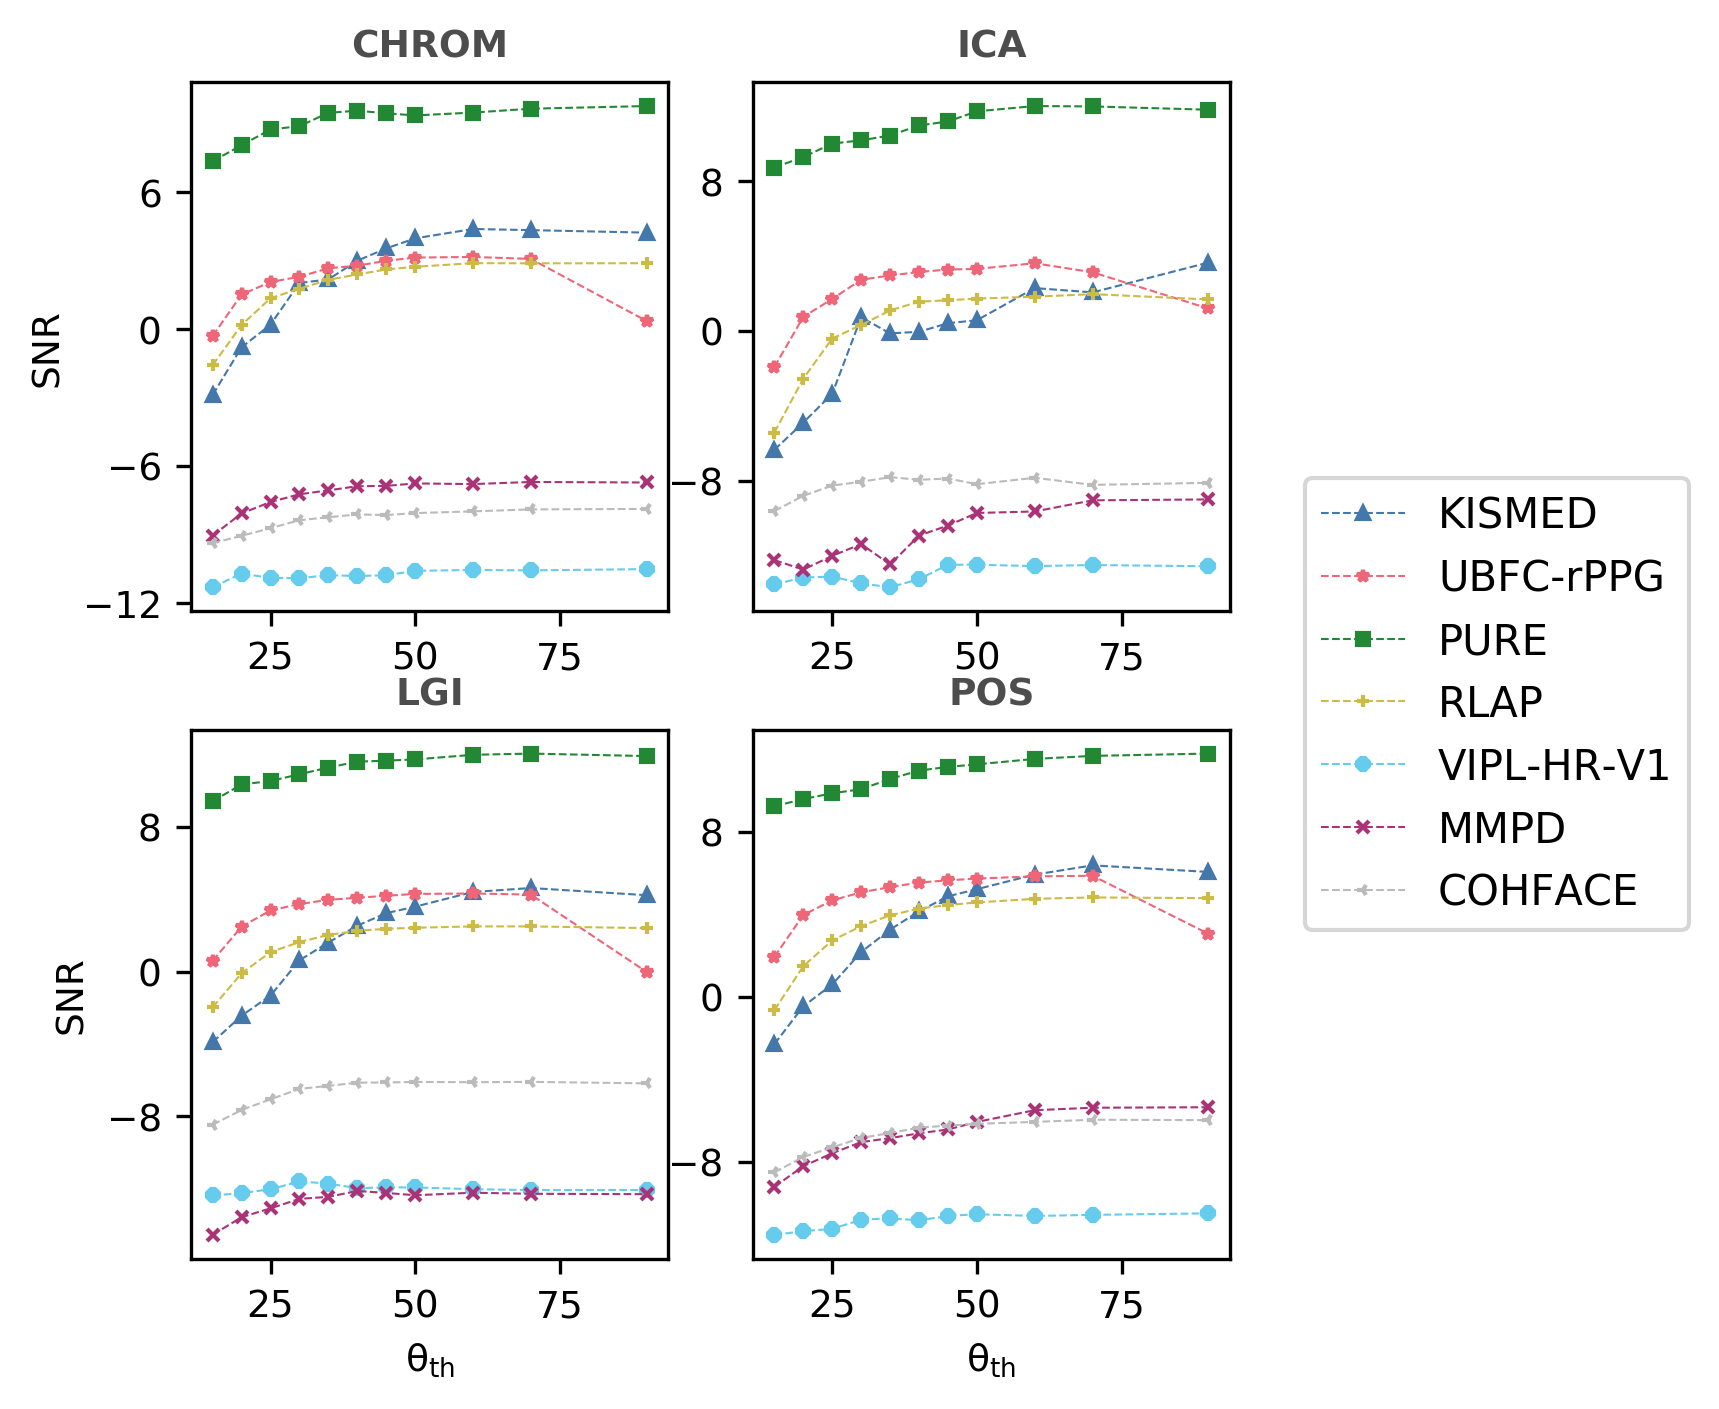

In [9]:
#Figure Poster
# Create a plot
from tol_colors import tol_cset
plt.rc('axes', prop_cycle=plt.cycler('color', list(tol_cset('bright'))))
#fig,axs = plt.subplots(2,2,figsize=(10, 6))      
plt.rcParams['mathtext.default']='regular' 
plt.rcParams['text.usetex'] = False
plt.rcParams['figure.dpi'] = 300
plt.rcParams['xtick.labelsize']=9 
plt.rcParams['ytick.labelsize']=9 
#plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(4.0, 4.5))
plt.subplots_adjust(hspace=0.5)

use_metric='SNR'


# Plot MAE over angle for each method
use_markers= ["^","*","s","+","8","x","3"]
for p_idx,method in enumerate([m for m in method_names if m not in ["PBV","GREEN"]]):
    for d_idx,d_name in enumerate(all_datasets):
        # Filter dataframe for the current method
        method_df = super_super_summary[(super_super_summary['method_name'] ==method) & (super_super_summary['dataset_name'] ==d_name)]
        
        # Plot MAE vs. angle
        ax = plt.subplot(2,2,p_idx+1)
        ax.plot(method_df['angle'].to_numpy(), method_df[use_metric].to_numpy(), label=d_name,marker=use_markers[d_idx],linestyle='--',linewidth=0.5,markersize=3)
    ax.set_title(method,fontsize=9,color=[0.3,0.3,0.3],weight='bold')
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))
    #ax.legend(loc='upper right')
    if p_idx==0 or p_idx==2:
        ax.set_ylabel(use_metric,fontsize=9)
    if p_idx==2 or p_idx==3:
        ax.set_xlabel('$θ_{th}$',fontsize=9)
    _max_value = super_super_summary[(super_super_summary['method_name'] ==method)][use_metric].max()
    if use_metric=="MAE":
        ax.set_yticks(np.arange(0.5,_max_value,np.round((_max_value-0.5)/3,1)))
    
#plt.legend(bbox_to_anchor=(0,1.02, 0.2,0.2), loc="upper left")
#plt.legend(loc='lower center', bbox_to_anchor=(-0.15,-0.6),ncol=2)
#ax.get_legend().set_title('Dataset')
fig = plt.gcf()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,loc='center right',ncol=1,bbox_to_anchor = (0.4, 0, 1, 1),
           bbox_transform = plt.gcf().transFigure)

# Add labels and title
# axs.xlabel('Angle')
# plt.ylabel('MAE')
# plt.title('MAE over Angle for each Method')
# plt.legend(title='Method')
plt.tight_layout(pad=0,rect=[0, 0, 1, 1])
plt.savefig(f"figs/angle_evaluation_poster_{use_metric}.svg",bbox_inches = 'tight')
plt.savefig(f"figs/angle_evaluation_poster_{use_metric}.png",bbox_inches = 'tight')
plt.savefig(f"figs/angle_evaluation_poster_{use_metric}.pdf",bbox_inches = 'tight')
#plt.savefig("figs/angle_evaluation.pgf",bbox_inches = 'tight') #requires latex installation
plt.show()


In [19]:


df = pd.read_csv("../data/HR_log/KISMED_SzW72_SzH72_ClipLen180_DataTypeRaw_DataAugNone_LabelTypeRaw_ROI_segmeTrue_Angle_thres30_Interp_AngleTrue_ROI_mode-optimal_roi_Use_convex_hullTrue_Constr_roiTrue_Outs_roiFalse_unsupervised/optimal_roi_POS.csv")


In [7]:
# From Column 90° mit ROI SEgmentierung from Tables 25-31
#methods= ["ICA","POS", "CHROM","GREEN","LGI","PBV"]
MAEs_best_region_Philipp = {'UBFC-rPPG':[1.08,1.42,1.89,21.91,1.40,4.46],'COHFACE':[10.76,7.67,11.23,14.54,7.18,11.97],'VIPL-HR-V1':[10.63,9.02,10.31,13.62,12.20,14.69],'PURE':[0.18,0.09,0.44,13.36,0.09,8.0],'MMPD':[21.11,14.10,18.24,23.17,17.67,22.74],'RLAP':[1.27,0.78,0.86,8.8,1.24,2.9],'KISMED':[2.2,0.53,1.05,8.53,0.7,1.58]}
# my 'UBFC-rPPG':[2.32,1.44,1.42,22.68,1.6,8.41], 'RLAP': [3.23,1.09,1.11,10.06,1.58,6.54]

In [13]:
# Note that improvement stems also from slight changes in code. Honest comparison should use current best ROI
sss_chrom = super_super_summary[super_super_summary["method_name"]=="CHROM"]
for angle in [15,20,25,30,35,40,45,50,60,70,90]:
    avg_improv = 0
    for dataset in all_datasets:
        MAE_angle = sss_chrom[(sss_chrom["angle"]==angle)&(sss_chrom["dataset_name"]==dataset)]["MAE"].item()
        MAE_best = MAEs_best_region_Philipp[dataset][2]
        avg_improv += MAE_best-MAE_angle
    avg_improv = avg_improv/len(all_datasets)
    print(f"Improvment for {angle}° = {avg_improv}")
        
        

Improvment for 15° = 0.023813152879152533
Improvment for 20° = 0.9958895447038311
Improvment for 25° = 0.7476455365984215
Improvment for 30° = 1.3004211963869925
Improvment for 35° = 1.2152030670305876
Improvment for 40° = 1.1195047358218173
Improvment for 45° = 1.3625457607852844
Improvment for 50° = 1.565718862961519
Improvment for 60° = 1.2536328352085433
Improvment for 70° = 1.2681081568836612
Improvment for 90° = 0.8835362048502343


In [20]:
df

,method_name,video_file,starting_frame,ending_frame,predict_hr_fft_all,gt_hr_fft_all,SNR_all
0,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,93.164062,94.921875,3.116686
1,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,94.921875,98.437500,5.317623
2,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,77.343750,103.710938,-8.866926
3,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,101.953125,101.953125,-1.203237
4,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,96.679688,96.679688,-13.343448
...,...,...,...,...,...,...,...
339,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,107.226562,103.710938,-5.946600
340,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,93.164062,93.164062,9.049239
341,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,94.921875,94.921875,9.446967
342,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,98.437500,98.437500,0.180414


In [25]:
scenarios = []
subjects = []
for i in range(df.shape[0]):
    scenarios.append(df["video_file"][i].split('/')[-1].replace('-','_').split('_')[1])
    subjects.append(df["video_file"][i].split('/')[-1].replace('-','_').split('_')[0])
df_manip = df.copy()
df_manip["scenario"]=scenarios
df_manip["subject"] = subjects


In [26]:
df_manip

,method_name,video_file,starting_frame,ending_frame,predict_hr_fft_all,gt_hr_fft_all,SNR_all,scenario,subject
0,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,93.164062,94.921875,3.116686,v01,p001
1,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,94.921875,98.437500,5.317623,v01,p001
2,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,77.343750,103.710938,-8.866926,v02,p001
3,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,101.953125,101.953125,-1.203237,v02,p001
4,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,96.679688,96.679688,-13.343448,v03,p001
...,...,...,...,...,...,...,...,...,...
339,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,107.226562,103.710938,-5.946600,v10,p010
340,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,93.164062,93.164062,9.049239,v11,p010
341,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,94.921875,94.921875,9.446967,v11,p010
342,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,98.437500,98.437500,0.180414,v12,p010


In [27]:
scenario_names = df_manip.scenario.unique()

In [30]:
df_manip[df_manip['scenario']==scenario_names[0]]

,method_name,video_file,starting_frame,ending_frame,predict_hr_fft_all,gt_hr_fft_all,SNR_all,scenario,subject
0,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,93.164062,94.921875,3.116686,v01,p001
1,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,94.921875,98.437500,5.317623,v01,p001
35,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,54.492188,54.492188,14.361044,v01,p002
36,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,54.492188,52.734375,15.679535,v01,p002
66,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,75.585938,77.343750,-1.634381,v01,p003
67,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,73.828125,73.828125,5.727604,v01,p003
101,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,68.554688,68.554688,16.108691,v01,p004
102,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,68.554688,65.039062,14.151675,v01,p004
136,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,0,900,89.648438,86.132812,-0.879608,v01,p005
137,POS,/home/rohr/data_cache/rppg_toolbox/preprocesse...,900,1800,91.406250,91.406250,1.536825,v01,p005


In [35]:
MAEs = []
RMSEs = []
SNR_m = []
errors = []
for sc in scenario_names:
    preds = df_manip[df_manip['scenario']==sc]['predict_hr_fft_all']
    gt = df_manip[df_manip['scenario']==sc]['gt_hr_fft_all']
    snrs = df_manip[df_manip['scenario']==sc]['SNR_all']
    errors.append(preds-gt)
    MAEs.append(np.mean(np.abs(preds-gt)))
    RMSEs.append(np.sqrt(np.mean((preds-gt)**2)))
    SNR_m.append(snrs.mean())
    
df_scenarios = pd.DataFrame({"scenario":scenario_names,"MAE":MAEs,"RMSE":RMSEs,"SNR_m":SNR_m})
df_scenarios
    

,scenario,MAE,RMSE,SNR_m
0,v01,0.966797,1.620623,7.378458
1,v02,6.416016,15.961286,1.261208
2,v03,12.568359,18.440283,-12.032986
3,v04,2.821752,4.624434,-3.998443
4,v05,12.304688,17.410799,-12.762054
5,v06,4.003906,7.240538,-0.235935
6,v07,25.683594,34.671957,-13.118618
7,v08,0.878906,1.470691,3.232510
8,v09,5.625000,10.576131,-4.615808
9,v10,13.710938,21.435224,-6.335098


/home/rohr/anaconda3/envs/rppg-toolbox/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


{'whiskers': [<matplotlib.lines.Line2D at 0x7efc4f1558b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7efc4f0e2280>,
 'boxes': [<matplotlib.lines.Line2D at 0x7efc4f155880>,
 'medians': [<matplotlib.lines.Line2D at 0x7efc4f0e28e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efc4f155820>,
 'means': []}

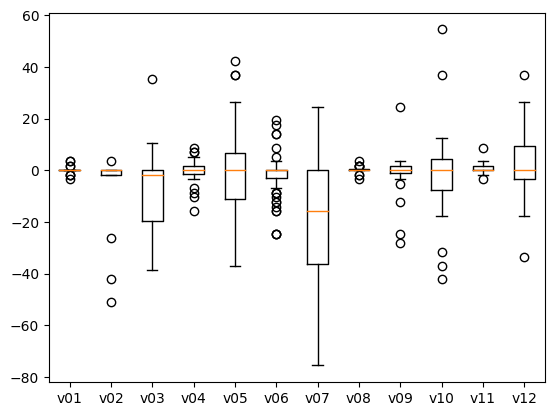

In [38]:
plt.figure()
plt.boxplot(errors,labels=scenario_names)

In [53]:
df_small = df_manip[(df_manip['predict_hr_fft_all']-df_manip['gt_hr_fft_all']).abs()<2]

In [48]:
df_small["scenario"].value_counts()

v06    65
v04    28
v01    20
v08    20
v11    19
v02    17
v09    15
v05    14
v03    10
v10     9
v12     9
v07     5
Name: scenario, dtype: int64

In [45]:
df_manip["scenario"].value_counts()

v06    90
v04    38
v05    38
v03    20
v10    20
v12    20
v09    20
v08    20
v01    20
v11    20
v02    20
v07    18
Name: scenario, dtype: int64

In [54]:
(df_small["scenario"].value_counts()/df_manip["scenario"].value_counts())

v01    0.850000
v02    0.800000
v03    0.350000
v04    0.657895
v05    0.342105
v06    0.633333
v07    0.222222
v08    0.900000
v09    0.550000
v10    0.400000
v11    0.850000
v12    0.450000
Name: scenario, dtype: float64